In [1]:
import os

import pandas as pd
import sqlalchemy
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

from shapely.geometry import Point
from folium.plugins import HeatMap
from IPython.display import display
from dotenv import load_dotenv

In [2]:
load_dotenv()
db = sqlalchemy.create_engine(f"postgresql+psycopg2://{os.getenv('DB_USERNAME')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOSTNAME')}/{os.getenv('DB_DATABASE')}",
                   connect_args={'sslmode': 'prefer'})

In [3]:
indications = pd.read_sql_table(table_name='ambulance_indication', con=db, schema='python')

In [4]:
indications

indication      indication_type seriousness is_certain  \
0    AK. REAKCE NA STRES  AK. REAKCE NA STRES        None     PRAVDA   
1            AK.RESP.SY.          AK.RESP.SY.        None     PRAVDA   
2              ALERG.R.-             ALERG.R.           -     PRAVDA   
3             ALERG.R.++             ALERG.R.          ++     PRAVDA   
4              ALERG.R.+             ALERG.R.           +     PRAVDA   
..                   ...                  ...         ...        ...   
178    ÚRAZ EL. PROUDEM?     ÚRAZ EL. PROUDEM        None   NEPRAVDA   
179    ÚRAZ EL.PROUDEM++      ÚRAZ EL.PROUDEM          ++     PRAVDA   
180      ÚRAZ EL.PROUDEM      ÚRAZ EL.PROUDEM        None     PRAVDA   
181     ÚRAZ EL.PROUDEM-      ÚRAZ EL.PROUDEM           -     PRAVDA   
182     ÚRAZ EL.PROUDEM+      ÚRAZ EL.PROUDEM           +     PRAVDA   

     indication_count  indication_type_count  
0                1304                   1304  
1                 325                    325  
2                 295                   4454  
3                 783                   4454  
4                 544                   4454  
..                ...                    ...  
178                10                     10  
179                14                    158  
180                88                    158  
181                31                    158  
182                25                    158  

[183 rows x 6 columns]

In [5]:
# health impact roughly summarised here: https://www.who.int/health-topics/heatwaves#tab=tab_2

In [6]:
# manualy created mapping of indication types that could be directly or indirectly related to heatwaves
# indications['indication_type'].drop_duplicates().to_excel('indication_types.xlsx', index=False)
indications_mapping = pd.read_csv('../data/interim/8_indication_mapping.csv', sep = ';')

In [7]:
indications_mapping

indication_type  heat_wave_indirect
0   AK. REAKCE NA STRES                   0
1           AK.RESP.SY.                   0
2              ALERG.R.                   0
3               ARTYMIE                   1
4               ARYTMIE                   1
..                  ...                 ...
90       ZŘÍCENÍ STAVBY                   0
91           ÚNIK LÁTKY                   0
92                 ÚRAZ                   0
93     ÚRAZ EL. PROUDEM                   0
94      ÚRAZ EL.PROUDEM                   0

[95 rows x 2 columns]

In [8]:
indications_complete = indications.merge(indications_mapping, left_on='indication_type', right_on='indication_type', how='left')

In [9]:
indications_complete

indication      indication_type seriousness is_certain  \
0    AK. REAKCE NA STRES  AK. REAKCE NA STRES        None     PRAVDA   
1            AK.RESP.SY.          AK.RESP.SY.        None     PRAVDA   
2              ALERG.R.-             ALERG.R.           -     PRAVDA   
3             ALERG.R.++             ALERG.R.          ++     PRAVDA   
4              ALERG.R.+             ALERG.R.           +     PRAVDA   
..                   ...                  ...         ...        ...   
178    ÚRAZ EL. PROUDEM?     ÚRAZ EL. PROUDEM        None   NEPRAVDA   
179    ÚRAZ EL.PROUDEM++      ÚRAZ EL.PROUDEM          ++     PRAVDA   
180      ÚRAZ EL.PROUDEM      ÚRAZ EL.PROUDEM        None     PRAVDA   
181     ÚRAZ EL.PROUDEM-      ÚRAZ EL.PROUDEM           -     PRAVDA   
182     ÚRAZ EL.PROUDEM+      ÚRAZ EL.PROUDEM           +     PRAVDA   

     indication_count  indication_type_count  heat_wave_indirect  
0                1304                   1304                   0  
1                 325                    325                   0  
2                 295                   4454                   0  
3                 783                   4454                   0  
4                 544                   4454                   0  
..                ...                    ...                 ...  
178                10                     10                   0  
179                14                    158                   0  
180                88                    158                   0  
181                31                    158                   0  
182                25                    158                   0  

[183 rows x 7 columns]

In [10]:
dispatched_vehicles =pd.read_sql_table(table_name='ambulance_measurements', con=db, schema='python')

In [11]:
dispatched_vehicles

id_call            date_time_call        date_time_dispatch  \
0       201803335701 2018-04-03 11:27:47+00:00 2018-04-03 11:27:47+00:00   
1       201803341201 2018-04-03 13:58:22+00:00 2018-04-03 13:59:18+00:00   
2       201803341401 2018-04-03 14:11:23+00:00 2018-04-03 14:12:40+00:00   
3       201803342001 2018-04-03 14:31:00+00:00 2018-04-03 14:32:43+00:00   
4       201803342601 2018-04-03 14:48:11+00:00 2018-04-03 14:49:43+00:00   
...              ...                       ...                       ...   
593990  202306961101 2023-06-30 21:46:07+00:00 2023-06-30 21:47:29+00:00   
593991  202306961201 2023-06-30 21:48:45+00:00 2023-06-30 21:50:33+00:00   
593992  202306961301 2023-06-30 21:50:46+00:00 2023-06-30 21:52:15+00:00   
593993  202306961401 2023-06-30 21:53:13+00:00 2023-06-30 21:54:10+00:00   
593994  202306961501 2023-06-30 21:56:35+00:00 2023-06-30 21:57:42+00:00   

                 date_time_scene dptr_base       indication  \
0      2018-04-03 11:32:28+00:00       STO      BEZVĚDOMÍ++   
1      2018-04-03 14:04:54+00:00       JME  NESP.NEURO.POT.   
2      2018-04-03 14:19:48+00:00       BRA   BOLEST BŘICHA+   
3      2018-04-03 14:40:05+00:00       BRA     J.POR.VĚDOMÍ   
4      2018-04-03 14:55:54+00:00       KUN       PO KOLAPSU   
...                          ...       ...              ...   
593990 2023-06-30 21:52:27+00:00       HOL      INTOXIKACE-   
593991 2023-06-30 21:52:15+00:00       NAD       INTOXIKACE   
593992 2023-06-30 22:01:14+00:00       BRA       PO KOLAPSU   
593993 2023-06-30 22:02:48+00:00       HRA           BOLEST   
593994 2023-06-30 22:01:56+00:00       MIC         ALERG.R.   

                     dptr_coordinates     lng     lat  \
0       50°2'40.5'' N, 14°18'53.8'' E  50.050  14.352   
1        50°2'5.7'' N, 14°30'52.6'' E  50.032  14.490   
2          14°24'38.6'' N, 50°2'6'' E  50.055  14.421   
3          50°2'4.6'' N, 14°24'38'' E  50.014  14.427   
4          14°29'5'' N, 50°6'53.7'' E  50.042  14.461   
...                               ...     ...     ...   
593990  50°5'47.2'' N, 14°25'51.4'' E  50.100  14.451   
593991  50°3'50.9'' N, 14°24'32.7'' E  50.062  14.408   
593992   50°2'4.7'' N, 14°24'38.4'' E  50.027  14.394   
593993  50°5'33.8'' N, 14°23'50.4'' E  50.090  14.453   
593994                         VZ MIC  50.065  14.457   

                                      hospital   date_time_arvl_hospital  \
0                                         None                       NaT   
1                                         None                       NaT   
2                                         None                       NaT   
3                                         None                       NaT   
4                                         None                       NaT   
...                                        ...                       ...   
593990                    Nemocnice Na Bulovce 2023-06-30 22:44:11+00:00   
593991                                                               NaT   
593992                                                               NaT   
593993                    Nemocnice Na Bulovce 2023-06-30 22:19:24+00:00   
593994  Fakultní nemocnice Královské Vinohrady 2023-06-30 22:43:51+00:00   

              date_time_handover   date_time_dptr_hospital  duration_min  \
0                            NaT                       NaT      4.683333   
1                            NaT                       NaT      5.600000   
2                            NaT                       NaT      7.133333   
3                            NaT                       NaT      7.366667   
4                            NaT                       NaT      6.183333   
...                          ...                       ...           ...   
593990 2023-06-30 22:51:33+00:00 2023-06-30 22:56:37+00:00      4.966667   
593991                       NaT 2023-06-30 22:11:52+00:00      1.700000   
593992                       NaT 2023-06-30 22:32:02+00:00   

<Axes: xlabel='date_time_dispatch'>

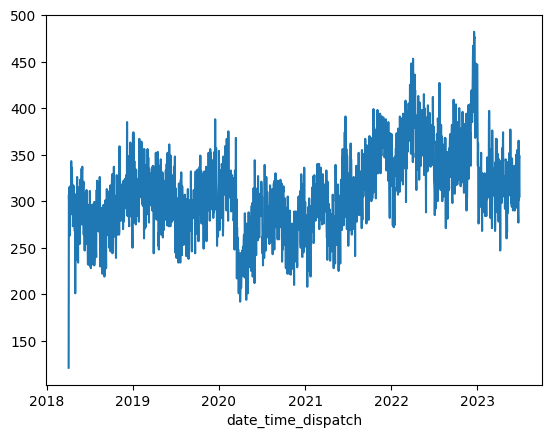

In [12]:
dispatched_vehicles.groupby(dispatched_vehicles.date_time_dispatch.dt.date)['id_call'].count().plot()

<Axes: xlabel='date_time_dispatch'>

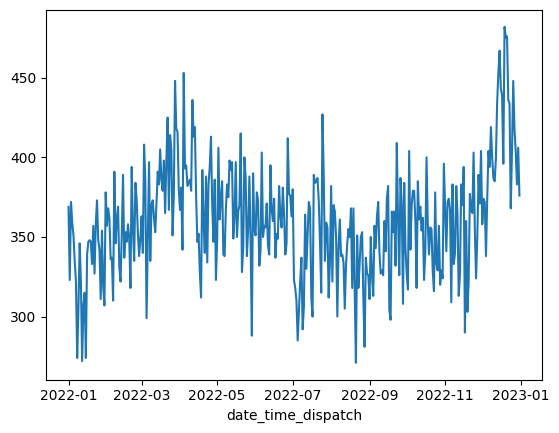

In [13]:
dispatched_vehicles[(dispatched_vehicles.date_time_dispatch >= '2022-01-01')
                    & (dispatched_vehicles.date_time_dispatch < '2023-01-01')].groupby(dispatched_vehicles.date_time_dispatch.dt.date)['id_call'].count().plot()

In [14]:
# filter for the possible heat wave related indications
filtered_dispatches = dispatched_vehicles[dispatched_vehicles.indication.isin(indications_complete[indications_complete.heat_wave_indirect == 1].indication)]

/var/folders/lq/00sdtv1n6s723w9y53z5s9800000gn/T/ipykernel_82877/2657266895.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_dispatches.groupby([filtered_dispatches.date_time_dispatch.dt.to_period('M').dt.start_time])['id_call'].count().plot()


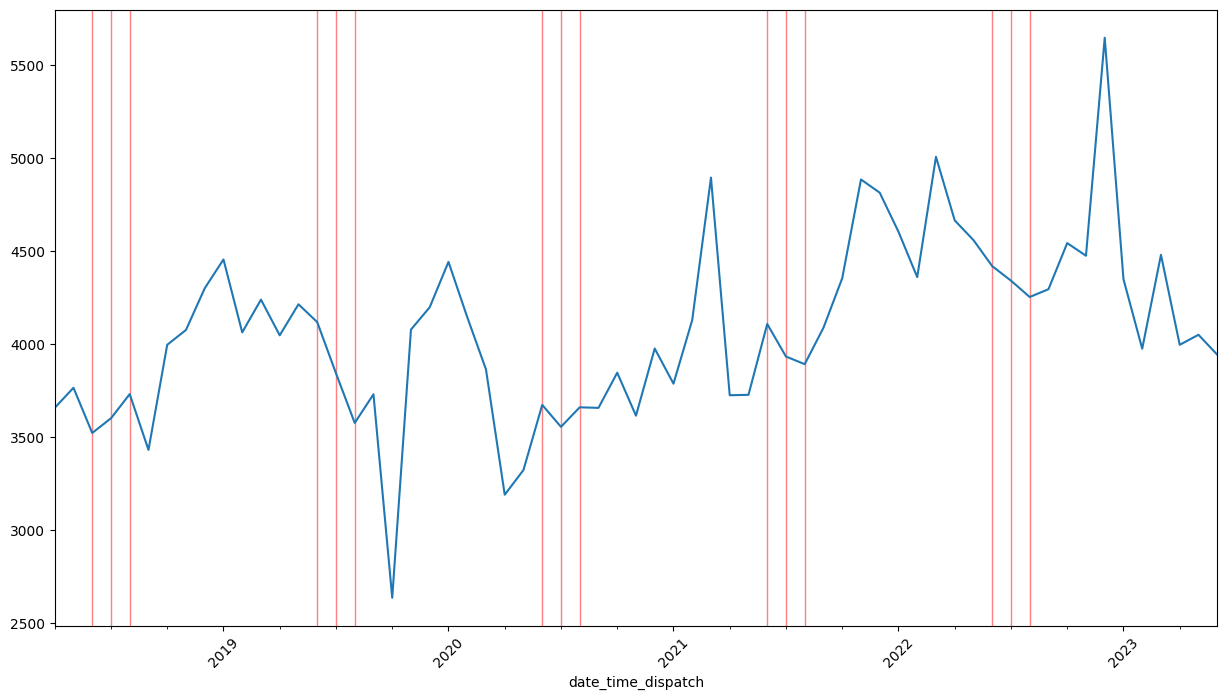

In [15]:
plt.figure(figsize=(15, 8))

filtered_dispatches.groupby([filtered_dispatches.date_time_dispatch.dt.to_period('M').dt.start_time])['id_call'].count().plot()

plt.xticks(rotation=45)
# BEGIN: Highlight summer months
summer_months = [6, 7, 8]
years = [2018, 2019, 2020, 2021, 2022]
for month in summer_months:
    for year in years:
        plt.axvspan(pd.Timestamp(f'{year}-{month}-01'), pd.Timestamp(f'{year}-{month}-01') + pd.offsets.MonthEnd(1), color='red', alpha=0.5)
# END: Highlight summer months
plt.show()

In [16]:
# Create a GeoDataFrame from filtered_dispatches
geometry = [Point(xy) for xy in zip(filtered_dispatches['lng'], filtered_dispatches['lat'])]
geo_filtered_dispatches = gpd.GeoDataFrame(filtered_dispatches, geometry=geometry)
geo_filtered_dispatches.set_crs(epsg=4326, inplace=True)

geo_filtered_dispatches.head()

id_call            date_time_call        date_time_dispatch  \
0  201803335701 2018-04-03 11:27:47+00:00 2018-04-03 11:27:47+00:00   
1  201803341201 2018-04-03 13:58:22+00:00 2018-04-03 13:59:18+00:00   
3  201803342001 2018-04-03 14:31:00+00:00 2018-04-03 14:32:43+00:00   
4  201803342601 2018-04-03 14:48:11+00:00 2018-04-03 14:49:43+00:00   
6  201803343301 2018-04-03 15:01:19+00:00 2018-04-03 15:02:07+00:00   

            date_time_scene dptr_base       indication  \
0 2018-04-03 11:32:28+00:00       STO      BEZVĚDOMÍ++   
1 2018-04-03 14:04:54+00:00       JME  NESP.NEURO.POT.   
3 2018-04-03 14:40:05+00:00       BRA     J.POR.VĚDOMÍ   
4 2018-04-03 14:55:54+00:00       KUN       PO KOLAPSU   
6 2018-04-03 15:08:13+00:00       PRO         DUŠNOST-   

                dptr_coordinates     lng     lat hospital  \
0  50°2'40.5'' N, 14°18'53.8'' E  50.050  14.352     None   
1   50°2'5.7'' N, 14°30'52.6'' E  50.032  14.490     None   
3     50°2'4.6'' N, 14°24'38'' E  50.014  14.427     None   
4     14°29'5'' N, 50°6'53.7'' E  50.042  14.461     None   
6  50°6'56.4'' N, 14°27'55.3'' E  50.115  14.466     None   

  date_time_arvl_hospital date_time_handover date_time_dptr_hospital  \
0                     NaT                NaT                     NaT   
1                     NaT                NaT                     NaT   
3                     NaT                NaT                     NaT   
4                     NaT                NaT                     NaT   
6                     NaT                NaT                     NaT   

   duration_min  is_valid               geometry  
0      4.683333      True   POINT (50.05 14.352)  
1      5.600000      True   POINT (50.032 14.49)  
3      7.366667      True  POINT (50.014 14.427)  
4      6.183333      True  POINT (50.042 14.461)  
6      6.100000      True  POINT (50.115 14.466)

In [54]:
geo_filtered_dispatches = geo_filtered_dispatches.loc[(~filtered_dispatches.lat.isnull()) & (filtered_dispatches.lng > 45)]

In [56]:
hm = folium.Map(location=[50.0864306, 14.4185472], zoom_start=10)
HeatMap(geo_filtered_dispatches[['lng','lat']], 
        min_opacity=0.4,
        blur = 18
               ).add_to(folium.FeatureGroup(name='Heat Map').add_to(hm))
folium.LayerControl().add_to(hm)
hm

In [58]:
geo_filtered_dispatches

id_call            date_time_call        date_time_dispatch  \
0       201803335701 2018-04-03 11:27:47+00:00 2018-04-03 11:27:47+00:00   
1       201803341201 2018-04-03 13:58:22+00:00 2018-04-03 13:59:18+00:00   
3       201803342001 2018-04-03 14:31:00+00:00 2018-04-03 14:32:43+00:00   
4       201803342601 2018-04-03 14:48:11+00:00 2018-04-03 14:49:43+00:00   
6       201803343301 2018-04-03 15:01:19+00:00 2018-04-03 15:02:07+00:00   
...              ...                       ...                       ...   
593979  202306959901 2023-06-30 20:45:32+00:00 2023-06-30 20:45:35+00:00   
593984  202306960501 2023-06-30 21:15:14+00:00 2023-06-30 21:16:10+00:00   
593986  202306960701 2023-06-30 21:23:46+00:00 2023-06-30 21:24:36+00:00   
593988  202306960901 2023-06-30 21:35:04+00:00 2023-06-30 21:36:21+00:00   
593992  202306961301 2023-06-30 21:50:46+00:00 2023-06-30 21:52:15+00:00   

                 date_time_scene dptr_base       indication  \
0      2018-04-03 11:32:28+00:00       STO      BEZVĚDOMÍ++   
1      2018-04-03 14:04:54+00:00       JME  NESP.NEURO.POT.   
3      2018-04-03 14:40:05+00:00       BRA     J.POR.VĚDOMÍ   
4      2018-04-03 14:55:54+00:00       KUN       PO KOLAPSU   
6      2018-04-03 15:08:13+00:00       PRO         DUŠNOST-   
...                          ...       ...              ...   
593979 2023-06-30 20:45:36+00:00       KOR  JINÉ AK. POTÍŽE   
593984 2023-06-30 21:19:55+00:00       JME  NESP.NEURO.POT.   
593986 2023-06-30 21:33:53+00:00       RAD          ARYTMIE   
593988 2023-06-30 21:40:30+00:00       MIC       HYPERTENZE   
593992 2023-06-30 22:01:14+00:00       BRA       PO KOLAPSU   

                      dptr_coordinates     lng     lat  \
0        50°2'40.5'' N, 14°18'53.8'' E  50.050  14.352   
1         50°2'5.7'' N, 14°30'52.6'' E  50.032  14.490   
3           50°2'4.6'' N, 14°24'38'' E  50.014  14.427   
4           14°29'5'' N, 50°6'53.7'' E  50.042  14.461   
6        50°6'56.4'' N, 14°27'55.3'' E  50.115  14.466   
...                                ...     ...     ...   
593979   50°4'30.9'' N, 14°27'18.2'' E  50.057  14.584   
593984      50°2'5'' N, 14°30'54.4'' E  50.032  14.503   
593986  49°59'31.5'' N, 14°20'43.7'' E  50.029  14.367   
593988     50°4'14'' N, 14°27'51.7'' E  50.077  14.446   
593992    50°2'4.7'' N, 14°24'38.4'' E  50.027  14.394   

                                           hospital   date_time_arvl_hospital  \
0                                              None                       NaT   
1                                              None                       NaT   
3                                              None                       NaT   
4                                              None                       NaT   
6                                              None                       NaT   
...                                             ...                       ...   
593979  Institut Klinické a experimentální medicíny 2023-06-30 22:29:58+00:00   
593984                    Městská poliklinika Praha 2023-06-30 21:56:39+00:00   
593986                                  FN v Motole 2023-06-30 22:03:45+00:00   
593988                 Všeobecná fakultní nemocnice 2023-06-30 22:08:25+00:00   
593992                                                                    NaT   

              date_time_handover   date_time_dptr_hospital  duration_min  \
0                            NaT                       NaT      4.683333   
1                            NaT                       NaT      5.600000   
3                            NaT                       NaT      7.366667   
4                            NaT                       NaT      6.183333   
6                            NaT                       NaT      6.100000   
...                          ...                       ...           ...   
593979                       NaT 2023-06-30 22:30:08+00:00      0.016667   
593984 2023-06-29 22:01:31+00:00 2023-06-30 22:04:56+00:00      3

In [59]:
geo_filtered_dispatches.to_file('../data/processed/8_heatwave_related_dispatches.json', driver="GeoJSON")

# Check correlation with heat waves

In [62]:
daily_heatwaves = pd.read_csv('../data/interim/daily_data_heatwaves.csv')

In [63]:
daily_heatwaves.head()

index  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun  \
0  2013-01-01   1.9   NaN   3.8   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
1  2013-01-02   3.8   NaN   5.9   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
2  2013-01-03   4.2   1.8   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
3  2013-01-04   7.9   5.2   9.6   1.5   NaN   NaN   NaN   NaN   NaN   NaN   
4  2013-01-05   7.6   NaN   NaN   8.9   NaN   NaN   NaN   NaN   NaN   NaN   

   year  month_of_year  day_of_year  tmax>30  tmin>20  rolling_28_3  \
0  2013              1            1    False    False           0.0   
1  2013              1            2    False    False           0.0   
2  2013              1            3    False    False           0.0   
3  2013              1            4    False    False           0.0   
4  2013              1            5    False    False           0.0   

   dwd_heatwave_day  days_elapsed annual_index  
0             False           NaN          NaN  
1             False           NaN          NaN  
2             False           NaN          NaN  
3             False           NaN          NaN  
4             False           NaN          NaN

In [78]:
daily_heatwaves.inde

RangeIndex(start=0, stop=4017, step=1)

In [79]:
daily_heatwaves_bool = daily_heatwaves.assign(date=pd.to_datetime(daily_heatwaves['index']))[['date', 'dwd_heatwave_day']]
geo_filtered_dispatches = geo_filtered_dispatches.assign(date=pd.to_datetime(geo_filtered_dispatches.date_time_dispatch.dt.date))

In [80]:
daily_heatwaves_bool

date  dwd_heatwave_day
0    2013-01-01             False
1    2013-01-02             False
2    2013-01-03             False
3    2013-01-04             False
4    2013-01-05             False
...         ...               ...
4012 2023-12-27             False
4013 2023-12-28             False
4014 2023-12-29             False
4015 2023-12-30             False
4016 2023-12-31             False

[4017 rows x 2 columns]

In [84]:
geo_filtered_dispatches_w_hw = geo_filtered_dispatches.merge(daily_heatwaves_bool, on = 'date', how='left')

In [ ]:
#todo: filter for summer months
#compare dispatch counts for heatwave days and non-heatwave days
# simple comparison of mean values, check distributions
# compare heatmaps